# LIP LANDMARKS EXPERIMENTS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tqdm

from sklearn.externals import joblib

import sys
sys.path.append('../')
import utils

In [2]:
kp = sio.loadmat('vid_kp_concat_keys.mat')['vidKp']
kp.shape

(1379020, 40)

In [11]:
lip_lms = np.reshape(kp, (-1, 2, 20))
lip_lms.shape

(1379020, 2, 20)

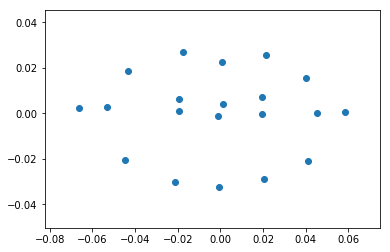

In [12]:
plt.scatter(lip_lms[0][0], -lip_lms[0][1])

In [9]:
lip_lms_wrong = np.reshape(kp, (-1, 20, 2))
lip_lms_wrong.shape

(1379020, 20, 2)

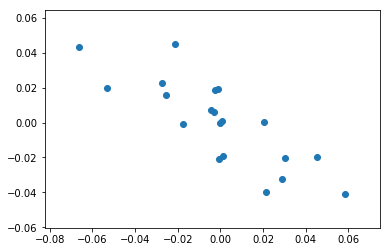

In [10]:
plt.scatter(lip_lms_wrong[0][:, 0], -lip_lms_wrong[0][:, 1])

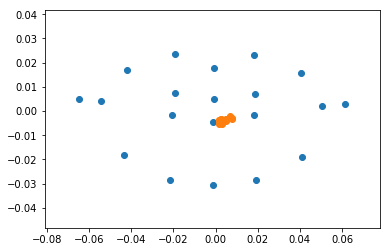

In [152]:
plt.scatter(np.mean(lip_lms[:, 0], axis=0), -np.mean(lip_lms[:, 1], axis=0))
plt.scatter(np.std(lip_lms[:, 0], axis=0), -np.std(lip_lms[:, 1], axis=0))

## Eigenvalues & Eigenvectors

In [5]:
def find_eigenvalues_and_eigenvectors_simply(A):
    L = 1 / len(A.T) * np.dot(A, A.T)
    e, u = np.linalg.eig(L)
    w = e
    v = np.dot(A.T, u)
    return w, v

def find_eigenvalues_and_eigenvectors(A):
    return np.linalg.eig(1 / len(A) * np.dot(A.T, A))

In [15]:
eigenvalues, eigenvectors = find_eigenvalues_and_eigenvectors(kp)

In [7]:
print(eigenvalues.shape, eigenvectors.shape)
print(eigenvectors)

(40,) (40, 40)
[[-0.38128419 -0.16731306 -0.39938551 ... -0.0078439   0.19732965
  -0.00283781]
 [-0.24650565 -0.06137271 -0.05909458 ...  0.41441296 -0.48222671
   0.30116018]
 [-0.11297425 -0.04733312  0.17887314 ...  0.0813396   0.14272349
  -0.12327379]
 ...
 [ 0.01061237 -0.2172106  -0.10331461 ...  0.02028029  0.05831923
   0.01875781]
 [ 0.02708417 -0.2197653  -0.0280241  ... -0.00743744 -0.03869525
  -0.0495482 ]
 [ 0.01022748 -0.24318576  0.02835372 ...  0.01195401  0.00391451
   0.03409036]]


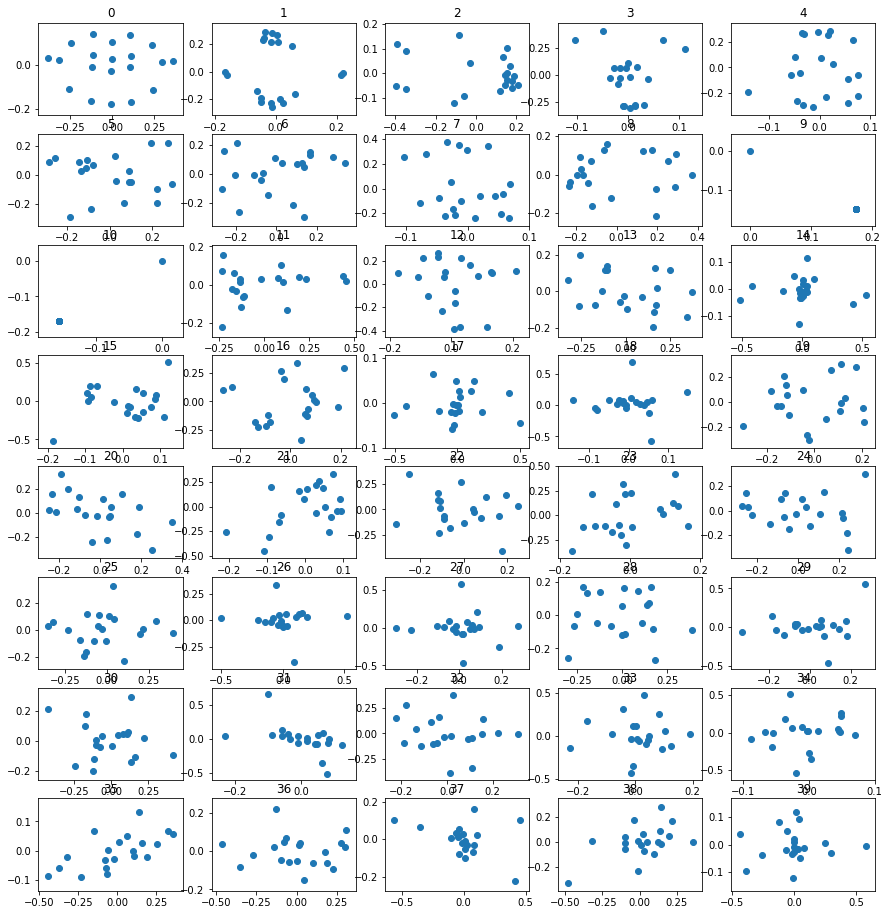

In [36]:
# Number of eigenfaces to be plotted
N = 40
plt.figure(figsize=(15, 2*(N+5)//5))
for i in range(N):
    # Make a subplot
    plt.subplot((N + 5)//5, 5, i+1)  
    # Remember eigenvectors are **columns** in the matrix
    plt.scatter(np.reshape(eigenvectors[:, i].T, (2, 20))[0], -np.reshape(eigenvectors[:, i].T, (2, 20))[1])
    plt.title(i)
#     plt.axis('off')

/users/voleti.vikram/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


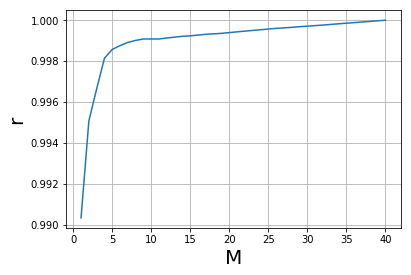

In [38]:
# Plot r vs M

# Values of M to consider: 1, 2,..., n
M = np.array(range(1, len(eigenvalues) + 1))

# Calculate r for all values of M
r = np.cumsum(eigenvalues)/np.sum(eigenvalues)

# Plot r vs M
plt.plot(M, r)
plt.xlabel("M", fontsize=20)
plt.ylabel("r", fontsize=20)
plt.grid("on")
plt.show()

# EXP 0. Remove landmarks that are all 0

In [161]:
count = 0
zero_i = []
for i, lm in tqdm.tqdm(enumerate(lip_lms), total=len(lip_lms)):
    if np.sum(lm) == 0:
        zero_i.append(i)
        count += 1

print(count)

100%|██████████| 1379020/1379020 [00:20<00:00, 65683.09it/s]

13638


In [162]:
lip_lms_wo_0 = np.delete(lip_lms, zero_i, axis=0)

In [163]:
lip_lms_wo_0.shape

(1365382, 2, 20)

# EXP 1. Align landmarks, set left at (-1, 0) and right at (1, 0)

In [154]:
def align_lm(lm):
    angle = np.arctan((lm[1, 6] - lm[1, 0])/(lm[0, 6] - lm[0, 0] + 1e-8))
    rot_lm = np.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]], lm)
    aligned_lm = (rot_lm - rot_lm[:, 0].reshape(2, 1)) / (np.max(rot_lm[0]) - np.min(rot_lm[0]) + 1e-8) * 2 - np.array([[1], [0]])
    aligned_lm[aligned_lm > 1.] = 1.
    aligned_lm[aligned_lm < -1.] = -1.
    return aligned_lm

In [164]:
aligned_lms_wo_0 = []
for lm in tqdm.tqdm(lip_lms_wo_0):
    aligned_lms_wo_0.append(align_lm(lm))

aligned_lms_wo_0 = np.array(aligned_lms_wo_0)

100%|██████████| 1365382/1365382 [02:47<00:00, 8167.89it/s]


In [165]:
# # np.save('vid_kp_concat_keys_aligned', aligned_lms)
# sio.savemat('vid_kp_concat_keys_aligned_wo_0.mat', {'vidKp': aligned_lms_wo_0.reshape(-1, 40)})

In [2]:
aligned_lms_wo_0 = sio.loadmat('vid_kp_concat_keys_aligned_wo_0.mat')['vidKp'].reshape(-1, 2, 20)

In [156]:
aligned_lms = []
for lm in tqdm.tqdm(lip_lms):
    aligned_lms.append(align_lm(lm))

aligned_lms = np.array(aligned_lms)

100%|██████████| 1379020/1379020 [02:45<00:00, 8343.17it/s]


In [157]:
# # np.save('vid_kp_concat_keys_aligned', aligned_lms)
# sio.savemat('vid_kp_concat_keys_aligned.mat', {'vidKp': aligned_lms.reshape(-1, 40)})

In [ ]:
aligned_lms = sio.loadmat('vid_kp_concat_keys_aligned.mat')['vidKp'].reshape(-1, 2, 20)

### Find eigenvectors and eigenvalues

In [144]:
eigenvalues_aligned, eigenvectors_aligned = find_eigenvalues_and_eigenvectors(aligned_lms.reshape(-1, 40))

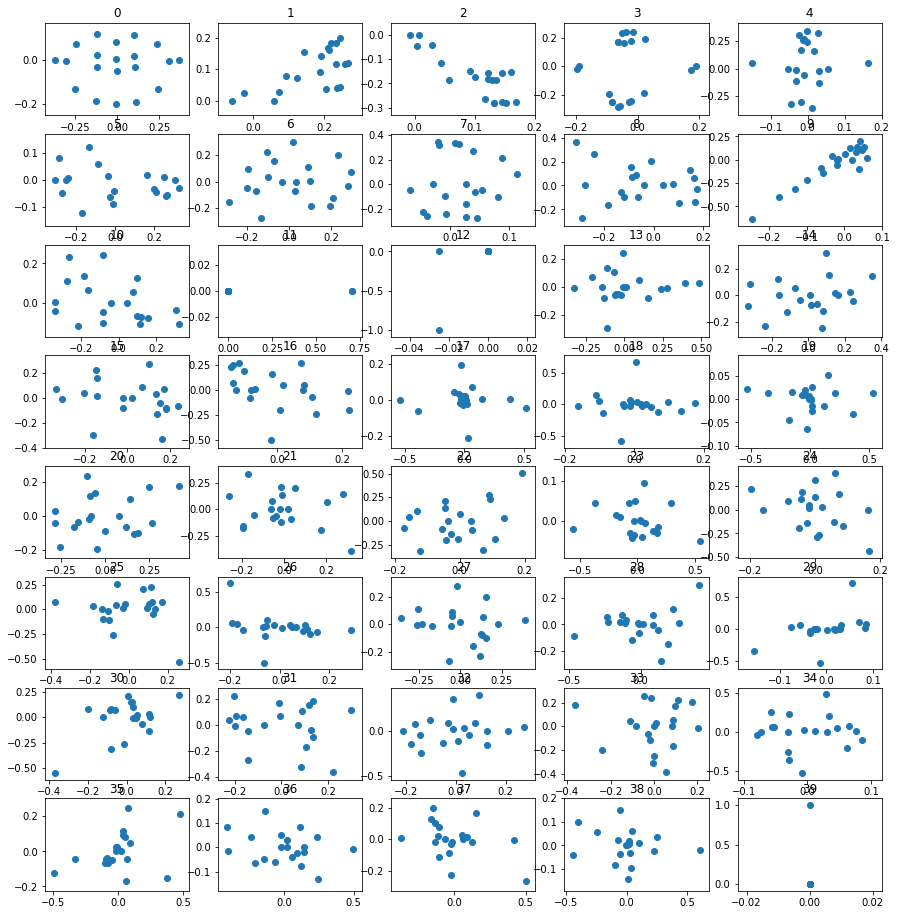

In [145]:
# Number of eigenfaces to be plotted
N = 40
plt.figure(figsize=(15, 2*(N+5)//5))
for i in range(N):
    # Make a subplot
    plt.subplot((N + 5)//5, 5, i+1)  
    # Remember eigenvectors are **columns** in the matrix
    plt.scatter(np.reshape(eigenvectors_aligned[:, i].T, (2, 20))[0], np.reshape(eigenvectors_aligned[:, i].T, (2, 20))[1])
    plt.title(i)
#     plt.axis('off')

/users/voleti.vikram/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


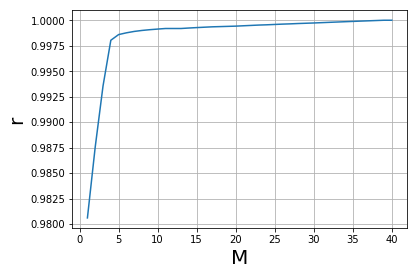

In [146]:
# Plot r vs M
# Values of M to consider: 1, 2,..., n
M = np.array(range(1, len(eigenvalues_aligned) + 1))
# Calculate r for all values of M
r = np.cumsum(eigenvalues_aligned)/np.sum(eigenvalues_aligned)
# Plot r vs M
plt.plot(M, r)
plt.xlabel("M", fontsize=20)
plt.ylabel("r", fontsize=20)
plt.grid("on")
plt.show()

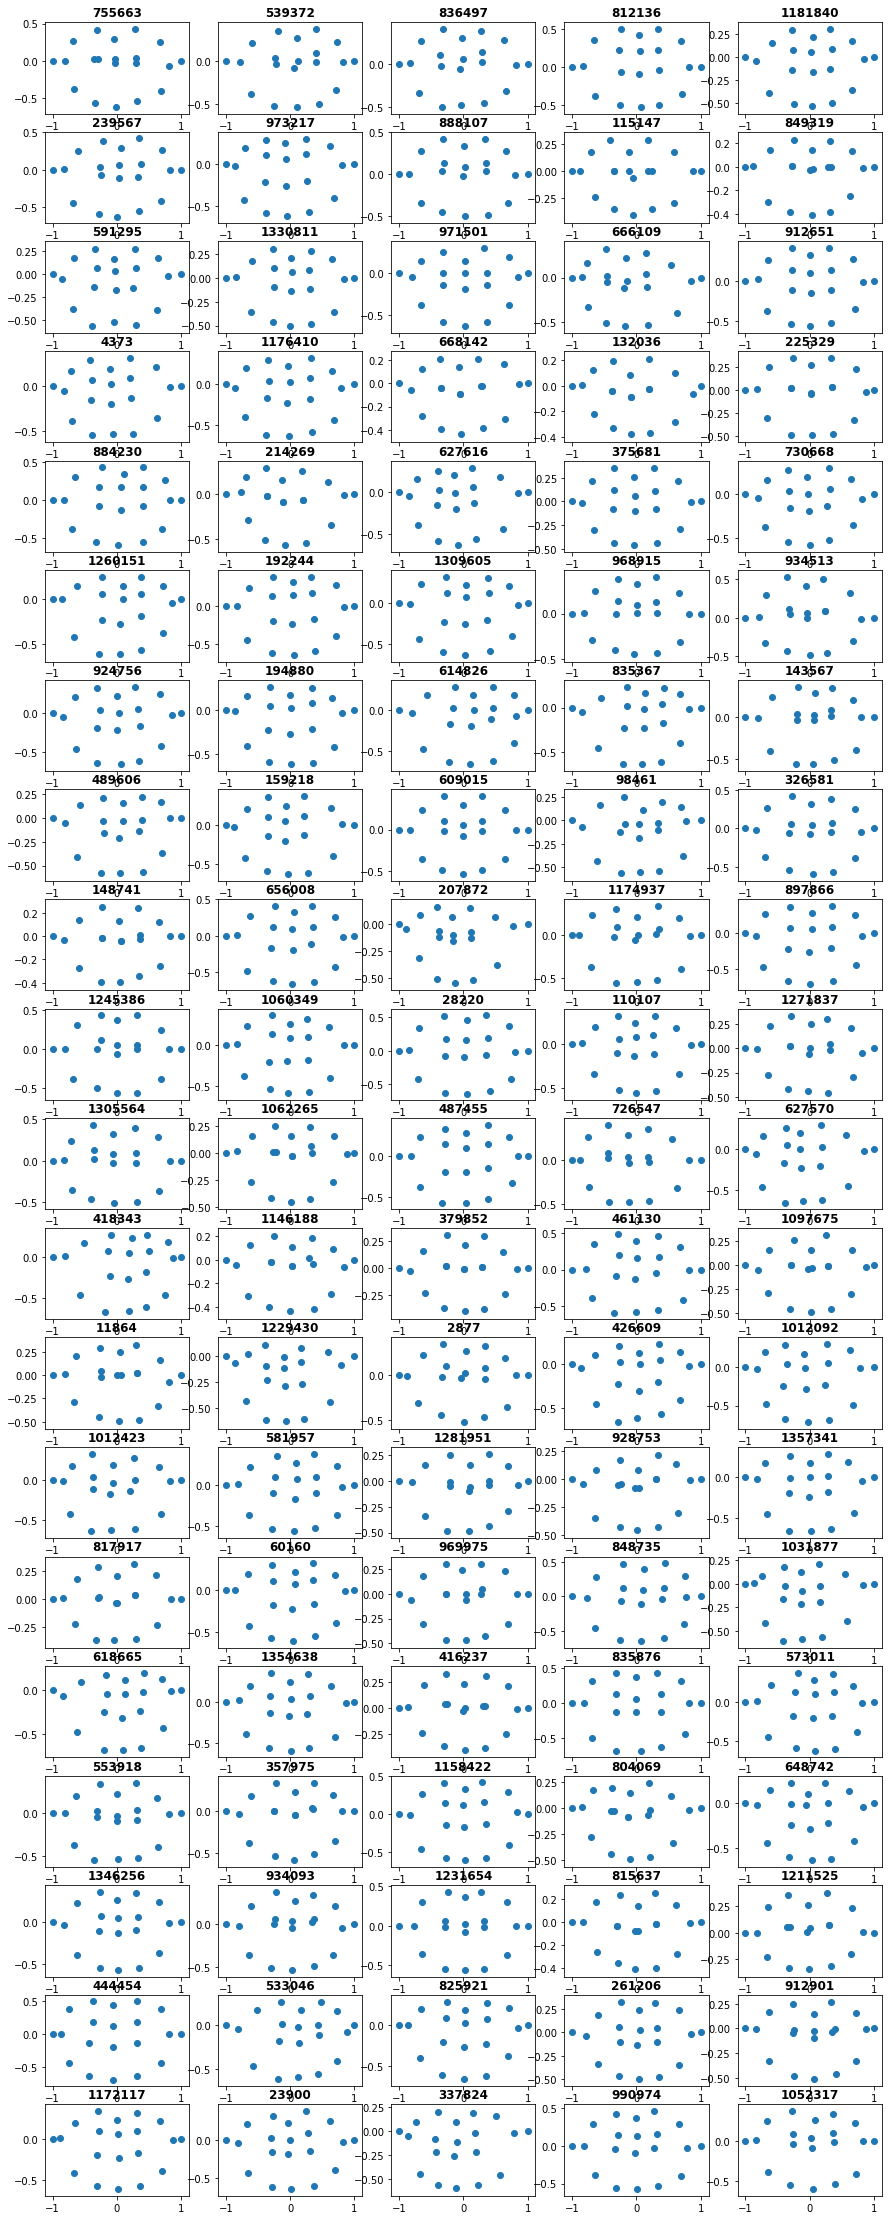

In [147]:
# Number of lips to be plotted
N = 100
plt.figure(figsize=(15, 2*(N+5)//5))
for i in range(N):
    k = np.random.choice(len(aligned_lms))
    # Make a subplot
    plt.subplot((N + 5)//5, 5, i+1)
    plt.scatter(aligned_lms[k][0], -aligned_lms[k][1])
    plt.title(k, fontweight='bold')
#     plt.axis('off')

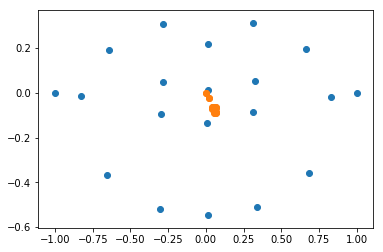

In [153]:
plt.scatter(np.mean(aligned_lms[:, 0], axis=0), -np.mean(aligned_lms[:, 1], axis=0))
plt.scatter(np.std(aligned_lms[:, 0], axis=0), -np.std(aligned_lms[:, 1], axis=0))

# EXP 2: Cluster aligned landmarks

In [3]:
aligned_lms_wo_0.shape

(1365382, 2, 20)

In [4]:
# Reshape to make all 68 landmarks in each row
aligned_lms_wo_0_reshaped = np.reshape(aligned_lms_wo_0, (len(aligned_lms_wo_0), -1))
aligned_lms_wo_0_reshaped.shape

(1365382, 40)

In [37]:
# Choose 10000 samples to fit on
fit_num = 10000
np.random.seed(29)
random_choice = np.random.choice(len(aligned_lms_wo_0_reshaped), fit_num, replace=False)
np.save('random_choice', random_choice)
random_choice = np.load('random_choice.npy')

In [38]:
random_choice

array([771344, 419727,  46931, ..., 314308, 276539, 228804])

## Visualize landmarks using t-SNE

In [39]:
random_lip_landmarks_raw = aligned_lms_wo_0_reshaped[random_choice]

In [40]:
%time random_lip_landmarks_raw_tsne = TSNE(n_components=2, verbose=1).fit_transform(random_lip_landmarks_raw)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.098s...
[t-SNE] Computed neighbors for 10000 samples in 14.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.061148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.310638
[t-SNE] Error after 1000 iterations: 1.877532
CPU times: user 10min 41s, sys: 

In [41]:
np.save('random_lip_landmarks_raw', random_lip_landmarks_raw)

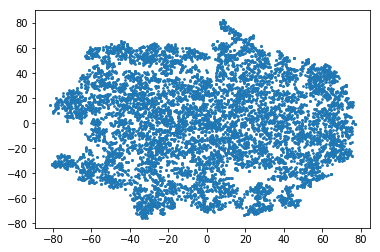

In [42]:
# 1000 points
plt.scatter(random_lip_landmarks_raw_tsne[:, 0], random_lip_landmarks_raw_tsne[:, 1], s=3)

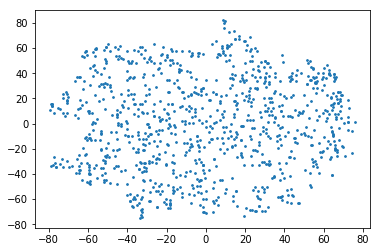

In [45]:
display_num = 1000
np.random.seed(29)
random_choice_to_display = np.random.choice(len(random_lip_landmarks_raw_tsne), display_num, replace=False)
np.save('random_choice_to_display', random_choice_to_display)
# np.load('random_choice_to_display.npy')
random_lip_landmarks_raw_tsne_to_display = random_lip_landmarks_raw_tsne[random_choice_to_display]
plt.scatter(random_lip_landmarks_raw_tsne_to_display[:, 0], random_lip_landmarks_raw_tsne_to_display[:, 1], s=3)

Comparison of clustering algorithms - http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## 1. Apply Spectral Clustering

Spectral Clustering - http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering

In [55]:
import sklearn.cluster

spectral_cluster_params = {
    'n_clusters'    : 18,
    'eigen_solver'  : None,
    'affinity'      : 'nearest_neighbors',
    'n_neighbors'   : 10,
    'assign_labels' : 'discretize'
}

spectral = sklearn.cluster.SpectralClustering(n_clusters=spectral_cluster_params['n_clusters'],
                                              eigen_solver=spectral_cluster_params['eigen_solver'],
                                              affinity=spectral_cluster_params['affinity'],
                                              n_neighbors=spectral_cluster_params['n_neighbors'],
                                              assign_labels=spectral_cluster_params['assign_labels'])

# Fit
%time spectral.fit(aligned_lms_wo_0_reshaped[random_choice])

CPU times: user 1min 41s, sys: 1.47 s, total: 1min 42s
Wall time: 1min 24s


SpectralClustering(affinity='nearest_neighbors', assign_labels='discretize',
          coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=18, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [56]:
# Save cluster
joblib.dump(spectral, 'aligned_lip_lms_spectral_cluster.pkl', compress=3)

['aligned_lip_lms_spectral_cluster.pkl']

In [57]:
# Predict labels
spectral_labels = spectral.labels_.astype(np.int)
unique_spectral_labels = np.unique(spectral_labels)
print(unique_spectral_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [58]:
# Cluster centres
spectral_cluster_centers = []
for i in range(len(unique_spectral_labels)):
    spectral_cluster_centers.append(np.mean(aligned_lms_wo_0_reshaped[random_choice][spectral_labels == i], axis=0))
    
spectral_cluster_centers = np.array(spectral_cluster_centers)

In [59]:
np.save('spectral_cluster_centers', spectral_cluster_centers)
spectral_cluster_centers = np.load('spectral_cluster_centers.npy')

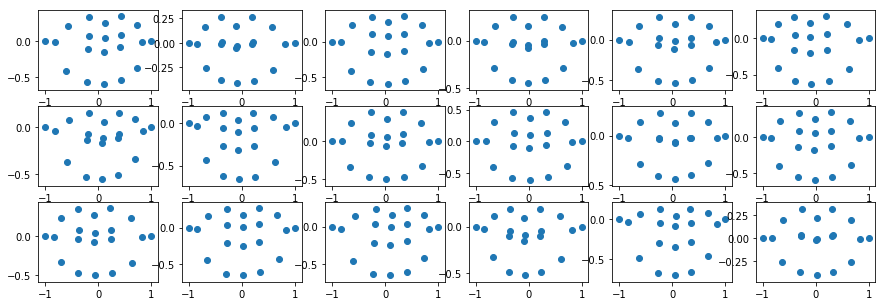

In [60]:
fig = plt.figure(figsize=(15, 5))

for i in range(18):
    ax = fig.add_subplot(3, 6, i+1)
    c = spectral_cluster_centers[i].reshape(2, 20)
    plt.scatter(c[0], -c[1])

## Visualize landmarks clusters using t-SNE

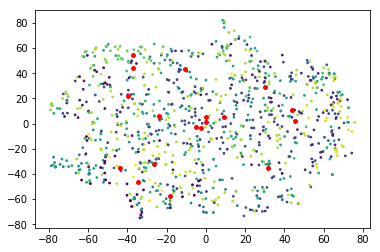

In [61]:
# Plot tSNE clusters
random_spectral_labels = gmm_labels[random_choice_to_display]
random_spectral_cluster_centers = []
for i in range(len(unique_spectral_labels)):
    random_spectral_cluster_centers.append(np.mean(random_lip_landmarks_raw_tsne_to_display[random_spectral_labels == i], axis=0))
    
random_spectral_cluster_centers = np.array(random_spectral_cluster_centers)

plt.scatter(random_lip_landmarks_raw_tsne_to_display[:, 0], random_lip_landmarks_raw_tsne_to_display[:, 1], s=3, c=random_spectral_labels)
plt.scatter(random_spectral_cluster_centers[:, 0], random_spectral_cluster_centers[:, 1], s=15, c='r')

## 2. Apply Gaussian Mixture Model

GMM - http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

In [46]:
import sklearn.mixture

gmm_params = {
    'n_clusters'       : 18,
    'covariance_type'  : 'full',
}

gmm = sklearn.mixture.GaussianMixture(n_components=gmm_params['n_clusters'],
                                      covariance_type=gmm_params['covariance_type'])

%time gmm.fit(aligned_lms_wo_0_reshaped[random_choice])

CPU times: user 1min 31s, sys: 1.66 s, total: 1min 32s
Wall time: 46.8 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=18, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [47]:
# Save cluster
joblib.dump(gmm, 'aligned_lip_lms_gaussian_mixture.pkl', compress=3)

['aligned_lip_lms_gaussian_mixture.pkl']

In [48]:
# Predict labels
gmm_labels = gmm.predict(aligned_lms_wo_0_reshaped[random_choice]).astype(np.int)
unique_gmm_labels = np.unique(gmm_labels)
print(unique_gmm_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [49]:
# Cluster centres
gmm_cluster_centers = []
for i in range(len(unique_gmm_labels)):
    gmm_cluster_centers.append(np.mean(aligned_lms_wo_0_reshaped[random_choice][gmm_labels == i], axis=0))
    
gmm_cluster_centers = np.array(gmm_cluster_centers)

In [50]:
np.save('gmm_cluster_centers', gmm_cluster_centers)
gmm_cluster_centers = np.load('gmm_cluster_centers.npy')

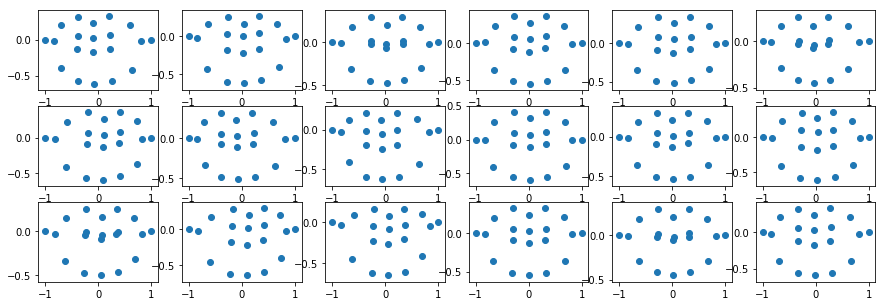

In [51]:
fig = plt.figure(figsize=(15, 5))

for i in range(18):
    ax = fig.add_subplot(3, 6, i+1)
    c = gmm_cluster_centers[i].reshape(2, 20)
    plt.scatter(c[0], -c[1])

## Visualize landmarks clusters using t-SNE

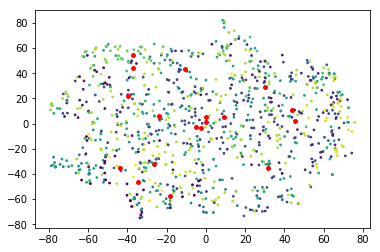

In [54]:
# Plot tSNE clusters
random_gmm_labels = gmm_labels[random_choice_to_display]
random_gmm_cluster_centers = []
for i in range(len(unique_gmm_labels)):
    random_gmm_cluster_centers.append(np.mean(random_lip_landmarks_raw_tsne_to_display[random_gmm_labels == i], axis=0))
    
random_gmm_cluster_centers = np.array(random_gmm_cluster_centers)

plt.scatter(random_lip_landmarks_raw_tsne_to_display[:, 0], random_lip_landmarks_raw_tsne_to_display[:, 1], s=3, c=random_gmm_labels)
plt.scatter(random_gmm_cluster_centers[:, 0], random_gmm_cluster_centers[:, 1], s=15, c='r')

# SCRATCHPAD

## Alignment

In [25]:
angles = [] 
for lm in tqdm.tqdm(lip_lms):
    angle = np.arctan((lm[1, 6] - lm[1, 0])/(lm[0, 6] - lm[0, 0] + 1e-8))
    angles.append(angle)
#     print(angle)
#     break

100%|██████████| 1379020/1379020 [00:13<00:00, 100490.55it/s]


In [26]:
angles = np.array(angles)

In [27]:
angles.shape

(1379020,)

0.01641125092510393
-1.3148416630367005e-09


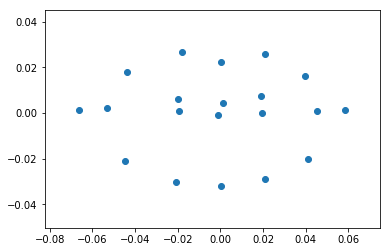

In [30]:
print(angles[0])
rot_lm = np.dot([[np.cos(angles[0]), np.sin(angles[0])], [-np.sin(angles[0]), np.cos(angles[0])]], lip_lms[0])
print(np.arctan((-rot_lm[1, 6] + rot_lm[1, 0])/(rot_lm[0, 6] - rot_lm[0, 0] + 1e-8)))
plt.scatter(rot_lm[0], -rot_lm[1])

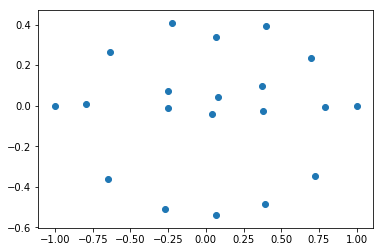

In [31]:
aligned_lm = (rot_lm - rot_lm[:, 0].reshape(2, 1)) / (np.max(rot_lm[0]) - np.min(rot_lm[0])) * 2 - np.array([[1], [0]])
plt.scatter(aligned_lm[0], -aligned_lm[1])

In [96]:
def align_lm(lm):
    angle = np.arctan((lm[1, 6] - lm[1, 0])/(lm[0, 6] - lm[0, 0] + 1e-8))
    rot_lm = np.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]], lm)
    aligned_lm = (rot_lm - rot_lm[:, 0].reshape(2, 1)) / (np.max(rot_lm[0]) - np.min(rot_lm[0])) * 2 - np.array([[1], [0]])
    return aligned_lm